In [2]:
cd ../TileEM/

/srv/data/home/jlee782/crowd-seg/analysis/TileEM


In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd
from analysis_toolbox import *
from qualityBaseline import *

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
def pixel_area(mask):
    return len(np.where(mask==1)[0])

In [115]:
lossiness_tbl = []
for objid in object_lst:
    gt_exact = ground_truth_T(objid)
    gt_pix = pkl.load(open("pixel_em/obj{}/gt.pkl".format(objid)))
    ratio = pixel_area(gt_pix)/gt_exact.area
    lossiness_tbl.append([objid,3,ratio,gt_exact.area]) # wid=3 is GT 

for bb in bb_info.iterrows():
    bb=bb[1]
    objid  = bb["object_id"]
    wid  = bb["worker_id"]
    if wid!=3:
        xloc,yloc =  process_raw_locs([bb["x_locs"],bb["y_locs"]]) 
        worker_BB_polygon=Polygon(zip(xloc,yloc))
        ratio = pixel_area(get_worker_mask(objid,wid))/worker_BB_polygon.area
        lossiness_tbl.append([objid,wid,ratio,worker_BB_polygon.area])

In [123]:
lossiness_tbl = pd.DataFrame(lossiness_tbl,columns=["objid","wid","ratio","exact obj area"])
lossiness_tbl["lossy rate"]=(1 - lossiness_tbl["ratio"])*100.

print lossiness_tbl.max()["lossy rate"]
print lossiness_tbl.min()["lossy rate"]
print lossiness_tbl.mean()["lossy rate"]
print lossiness_tbl.std()["lossy rate"]

-0.464389808526
-23.2558139535
-3.1365506423
2.37876035912


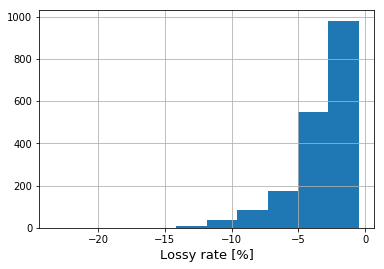

In [124]:
lossiness_tbl["lossy rate"].hist()
plt.xlabel("Lossy rate [%]",fontsize=13)

In [125]:
len(lossiness_tbl)

1832

Loss rate is defined as 1 - [GT pixel based area/GT (tile based) exact area], which quantifies how much information is lost due to the rasterization (converting from polygon coordinates of bounding box to pixel mask). This ratio is computed for all worker bounding boxes and ground truths. The max loss rate is 23.25% min is 0.46%, the average loss rate is around 3.14%.

# Visualizing overplotting Tile on pixel mask 

In [106]:
lossiness_tbl[(lossiness_tbl["wid"]==3)&(lossiness_tbl["lossy rate"]<-10)]

,objid,wid,ratio,lossy rate
14,15,3,1.103149,-10.314875


(80, 40)

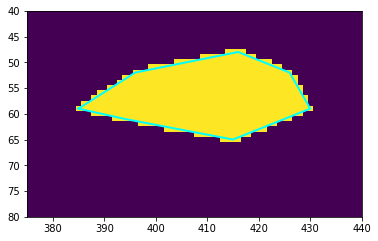

In [111]:
objid=15
gt_exact = ground_truth_T(objid,reverse_xy=True)
gt_pix = pkl.load(open("pixel_em/obj{}/gt.pkl".format(objid)))
plt.imshow(gt_pix)
plot_coords(gt_exact,'cyan')
plt.xlim(375,440)
plt.ylim(80,40)

In [112]:
lossiness_tbl[(lossiness_tbl["wid"]==3)&(lossiness_tbl["lossy rate"]<-8)]

,objid,wid,ratio,lossy rate
5,6,3,1.088785,-8.878505
14,15,3,1.103149,-10.314875
40,41,3,1.082484,-8.248378


(260, 195)

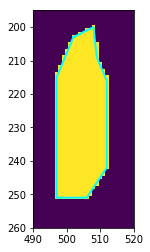

In [119]:
objid=6
gt_exact = ground_truth_T(objid,reverse_xy=True)
gt_pix = pkl.load(open("pixel_em/obj{}/gt.pkl".format(objid)))
plt.imshow(gt_pix)
plot_coords(gt_exact,'cyan')
plt.xlim(490,520)
plt.ylim(260,195)

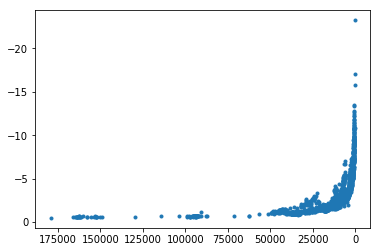

In [127]:
plt.plot(lossiness_tbl["exact obj area"],lossiness_tbl["lossy rate"],'.')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# Smaller areas are correlated with larger lossy rates 

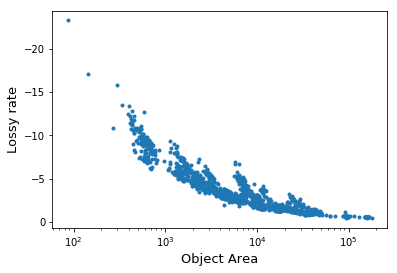

In [132]:
plt.semilogx(lossiness_tbl["exact obj area"],lossiness_tbl["lossy rate"],'.')
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Object Area",fontsize=13)
plt.ylabel("Lossy rate",fontsize=13)